In [89]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox

# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy import signal
from scipy import stats

sys.path.append("..")
from eda_utilities import print_eda_stats
from data_pipeline import dockless_data_pipeline
from data_pipeline import weather_data_pipeline

In [11]:
# Read the dockless data from S3 bucket
# Load the data and and call the clean method automatically to call the work flow
dockless_data = pd.read_csv("https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Dockless_Vehicle_Trips.csv")
dockless_vehicles_columns = dockless_data.columns
print_eda_stats(dockless_data, dockless_vehicles_columns, "Austin Dockless Mobility Data")
# Call the dockless_data_pipeline()
dockless_data_pipeline(dockless_data)
dockless_vehicles_columns = dockless_data.columns
print_eda_stats(dockless_data, dockless_vehicles_columns, "Austin Dockless Mobility Data")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


+--------------------------+---------+-------------+---------------+--------------+-------------------+
|       Column Name        |  dtype  | Total_Count | Unique_Values | df_totalrows | Null Value counts |
+--------------------------+---------+-------------+---------------+--------------+-------------------+
|            ID            |  object |   2746505   |    2746505    |   2746505    |         0         |
|        Device ID         |  object |   2746505   |     26999     |   2746505    |         0         |
|       Vehicle Type       |  object |   2746504   |       3       |   2746505    |         1         |
|      Trip Duration       | float64 |   2746504   |     10521     |   2746505    |         1         |
|      Trip Distance       | float64 |   2746504   |     16125     |   2746505    |         1         |
|        Start Time        |  object |   2746504   |     25694     |   2746505    |         1         |
|         End Time         |  object |   2746504   |     25768  

In [12]:
#Read the weather data from S3 bucket
weather_data = pd.read_csv("https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Bergstom_Airport_Weather.csv")
weather_columns = weather_data.columns
print_eda_stats(weather_data, weather_columns, "Austin Weather Data")
weather_data_pipeline(weather_data)
weather_columns = weather_data.columns
print_eda_stats(weather_data, weather_columns, "Austin Weather Data")

+-----------------+---------+-------------+---------------+--------------+-------------------+
|   Column Name   |  dtype  | Total_Count | Unique_Values | df_totalrows | Null Value counts |
+-----------------+---------+-------------+---------------+--------------+-------------------+
|     STATION     |  object |     436     |       1       |     436      |         0         |
|       NAME      |  object |     436     |       1       |     436      |         0         |
|     LATITUDE    | float64 |     436     |       1       |     436      |         0         |
|    LONGITUDE    | float64 |     436     |       1       |     436      |         0         |
|    ELEVATION    | float64 |     436     |       1       |     436      |         0         |
|       DATE      |  object |     436     |      436      |     436      |         0         |
|       AWND      | float64 |     435     |       73      |     436      |         1         |
| AWND_ATTRIBUTES |  object |     435     |       

In [14]:
# Drop all records where  trip distance is less .1 miles and greater than 500 miles (1609.34 mts - 804673 mts)
dockless_data = dockless_data[(dockless_data['Trip Distance'] > 1609.34) & (dockless_data['Trip Distance'] < 804673)]
dockless_data = dockless_data[(dockless_data['Trip Duration'] > 60) & (dockless_data['Trip Duration'] < 86400)]

In [27]:
# Add to pipeline so it easy for calculations (Done)
# dockless_data['count'] = 1

# Have only weather data which is from the start date of the scooter data
trip_counts = dockless_data.groupby('START_DATE').count()['count']
weather_data= weather_data[weather_data['DATE'] >= trip_counts.index.min()]
weather_data= weather_data[weather_data['DATE'] <= trip_counts.index.max()]
weather_data = weather_data.reset_index()

In [33]:
grouped_origin_cell_id = dockless_data.groupby(['Origin Cell ID']).agg('count')
grouped_origin_cell_id = grouped_origin_cell_id.sort_values(['Trip Duration'], ascending=False)
top_origin_cell_ids = grouped_origin_cell_id['Trip Duration']
# Rename the column Trip Duration to Trip Counts
top_origin_cell_ids = top_origin_cell_ids.to_frame().reset_index()
top_50_origin_cells = top_origin_cell_ids.head(50)
top_50_origin_cells.to_csv("../../output/EDA/Top_50_Origin_Cells_Total_Rides.csv")
top_10_origin_cells = top_50_origin_cells[0:10]
top_10_origin_cells = top_10_origin_cells['Origin Cell ID'].values
top_10_origin_cells_list = top_10_origin_cells.tolist()

In [20]:
# Make the DateTime as index
dockless_data = dockless_data.reset_index()
dockless_data = dockless_data.set_index("Start Time")
origin_cell_data = dockless_data[['Origin Cell ID', 'count']]

In [34]:
top_10_origin_cell_data = origin_cell_data[origin_cell_data['Origin Cell ID'].isin(top_10_origin_cells_list)]

In [36]:
top_10_origin_cell_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 111901 entries, 2018-10-22 16:15:00 to 2019-02-08 17:45:00
Data columns (total 2 columns):
Origin Cell ID    111901 non-null object
count             111901 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.6+ MB


In [43]:
top_10_origin_cell_data.head(5)

,Origin Cell ID,count
Start Time,,
2018-10-22 16:15:00,015019,1
2018-10-04 10:30:00,014707,1
2018-09-03 16:30:00,015019,1
2018-09-16 16:00:00,014864,1
2018-10-09 20:30:00,015019,1


In [44]:
# Top 3 origin cell data
cell_014706_data = top_10_origin_cell_data[top_10_origin_cell_data['Origin Cell ID'] == '014706']
cell_013650_data = top_10_origin_cell_data[top_10_origin_cell_data['Origin Cell ID'] == '013650']
cell_013176_data = top_10_origin_cell_data[top_10_origin_cell_data['Origin Cell ID'] == '013176']

In [97]:
trip_counts_cell_014706 = cell_014706_data.groupby([cell_014706_data.index.get_level_values(0),'Origin Cell ID']).count()
trip_counts_cell_014706 = trip_counts_cell_014706.unstack(level=1)
trip_counts_cell_014706 = trip_counts_cell_014706.fillna(0)

# Make a regular dataframe for processing the Time Series
t2 = trip_counts_cell_014706.reset_index()['count']
counts = t2['014706'].values
data = {'Start Time':trip_counts_cell_014706.index.values, '014706':counts} 
trip_counts_cell_014706_new = pd.DataFrame(data)
data_014706 = trip_counts_cell_014706_new.set_index("Start Time")



In [108]:
# data after '2018-07-15'

data_014706 = data_014706[(data_014706.index > '2018-07-15')]
data_014706.head(5)

,014706
Start Time,
2018-07-15 00:30:00,1
2018-07-15 07:45:00,1
2018-07-15 09:15:00,1
2018-07-15 09:30:00,2
2018-07-15 10:45:00,1


In [124]:

def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Dockless Scooter Trend For {}".format(name))

def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)
    
def fit_moving_average_trend(series, window=6):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.set_title("Dockless Scooter Moving Average Trend For {}".format(name))
    ax.plot(series.index, moving_average_trend)
    
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(month).ix[:, :11]

def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.set_title("Dockless Scooter Seasonality Trend For {}".format(name))
    ax.plot(series.index, seasons_average_trend)
    
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

In [99]:
#trip_counts_cell_014706.head(5)

In [100]:
#trip_counts_cell_014706.index.values

In [101]:
# t2 = trip_counts_cell_014706.reset_index()['count']
# counts = t2['014706'].values

In [102]:
# data = {'Start Time':trip_counts_cell_014706.index.values, '014706':counts} 
# trip_counts_cell_014706_new = pd.DataFrame(data)
# data_014706 = trip_counts_cell_014706_new.set_index("Start Time")


In [139]:
data_014706_hourly = data_014706.resample('H', how='mean')
data_014706_hourly = data_014706_hourly.fillna(0)
data_014706_hourly.head(5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  """Entry point for launching an IPython kernel.


,014706
Start Time,
2018-07-15 00:00:00,1.0
2018-07-15 01:00:00,0.0
2018-07-15 02:00:00,0.0
2018-07-15 03:00:00,0.0
2018-07-15 04:00:00,0.0


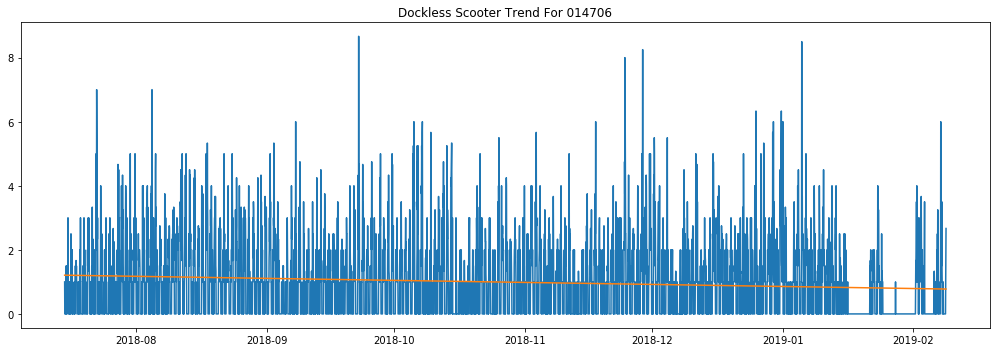

In [140]:
fig, ax = plt.subplots(1, figsize=(14, 5))
plot_linear_trend(ax, '014706', data_014706_hourly['014706'])
plt.tight_layout()

##### From the graph above you can see there is no linear trend

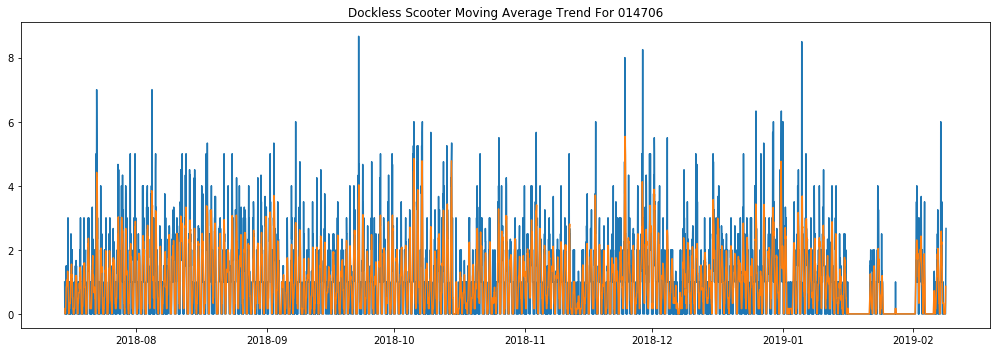

In [141]:
fig, ax = plt.subplots(1, figsize=(14, 5))
plot_moving_average_trend(ax, '014706', data_014706_hourly['014706'])
plt.tight_layout()

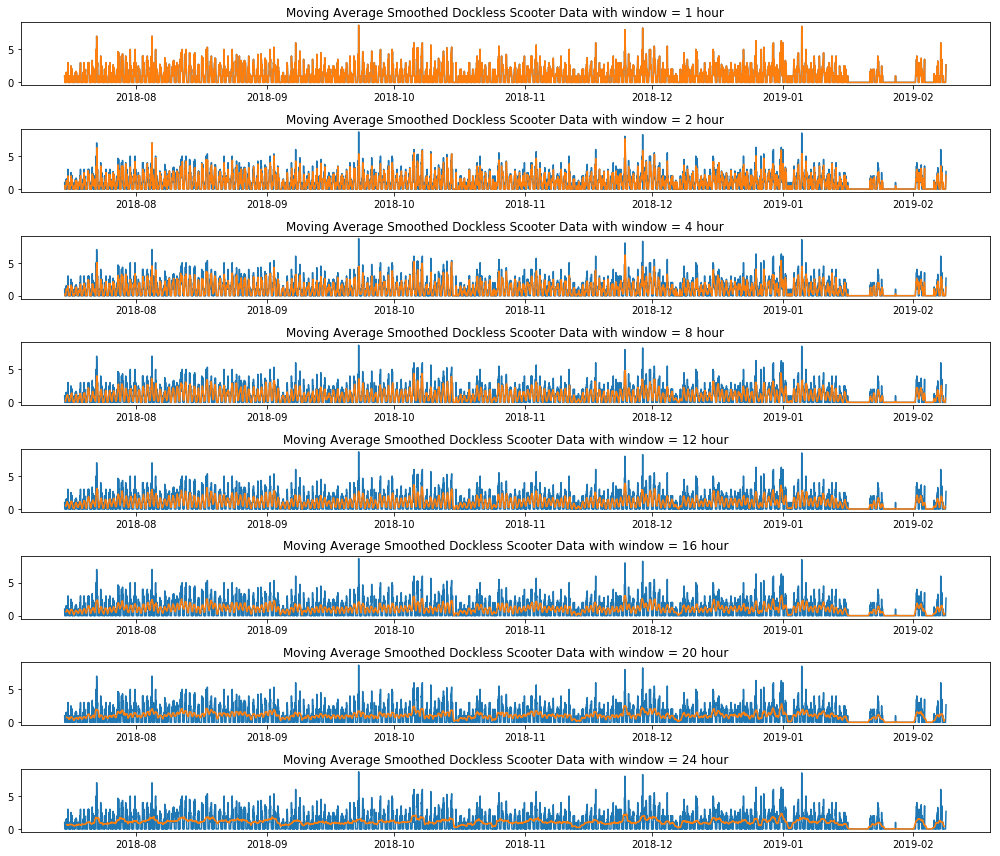

In [145]:
fig, axs = plt.subplots(8, figsize=(14, 12))

#gmail_series = google_trends['gmail']
for i, window in enumerate([1, 2, 4, 8, 12, 16, 20, 24]):
    axs[i].plot(data_014706_hourly.index, data_014706_hourly)
    axs[i].plot(data_014706_hourly.index, fit_moving_average_trend(data_014706_hourly, window=window))
    axs[i].set_title("Moving Average Smoothed Dockless Scooter Data with window = {} hour".format(window))
    
plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


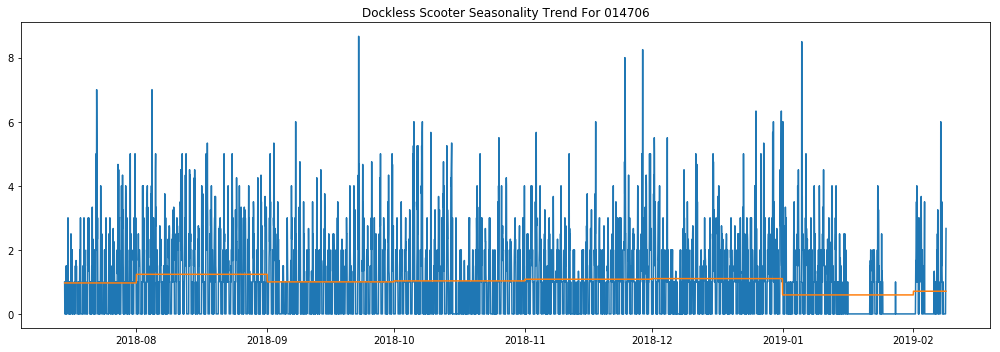

In [146]:
fig, axs = plt.subplots(1, figsize=(14, 5))

plot_seasonal_trend(axs, '014706', data_014706_hourly['014706'])

plt.tight_layout()

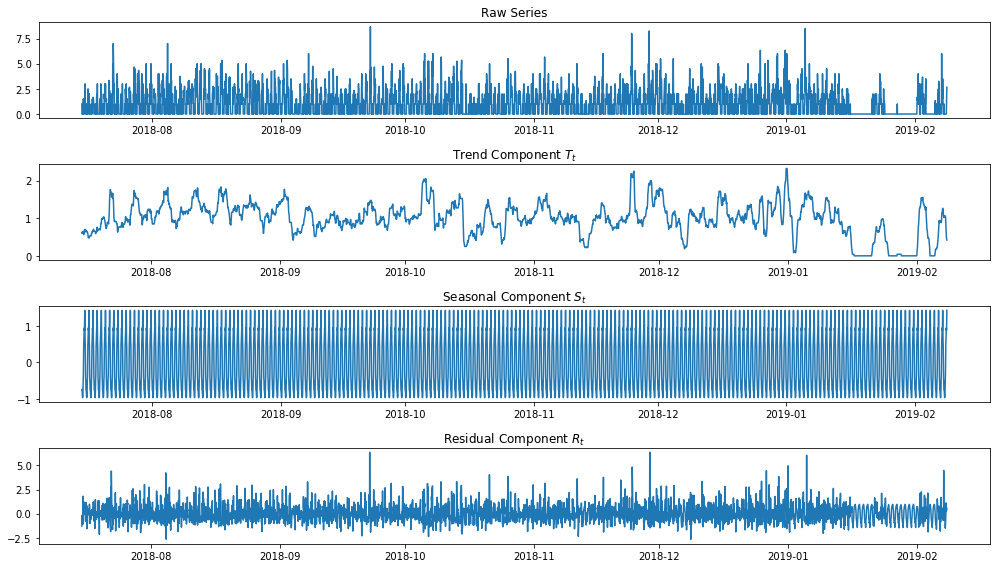

In [147]:
data_014706_decomposition = sm.tsa.seasonal_decompose(data_014706_hourly['014706'])

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, data_014706_hourly['014706'], data_014706_decomposition)
plt.tight_layout()

In [130]:
data_014706.head(5)

,014706
Start Time,
2018-07-15 00:30:00,1
2018-07-15 07:45:00,1
2018-07-15 09:15:00,1
2018-07-15 09:30:00,2
2018-07-15 10:45:00,1


In [137]:
t2 = data_014706.resample('H', how='mean')
t2 = t2.fillna(0)
t2.head(5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  """Entry point for launching an IPython kernel.


,014706
Start Time,
2018-07-15 00:00:00,1.0
2018-07-15 01:00:00,0.0
2018-07-15 02:00:00,0.0
2018-07-15 03:00:00,0.0
2018-07-15 04:00:00,0.0


In [138]:
t2['014706'].max()

8.666666666666666

In [150]:
month_value = data_014706.index.month
month_value

Int64Index([7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
            ...
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
           dtype='int64', name='Start Time', length=6055)

In [151]:
print("Sameera")

Sameera
